<a href="https://colab.research.google.com/github/BD157/MLE-Capstone-BD/blob/main/Step_8_Method_2_Memory_Batching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clean slate and reinstall correct versions
!pip uninstall -y numpy pandas scipy gensim umap-learn thinc spacy
!pip install -q numpy==1.26.4 pandas==2.2.2 scipy==1.11.4
!pip install -q gensim==4.3.2 umap-learn==0.5.5

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Found existing installation: umap-learn 0.5.5
Uninstalling umap-learn-0.5.5:
  Successfully uninstalled umap-learn-0.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires spacy<4, which is not installed.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.


In [ ]:
import gensim
import umap
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
# Mound Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Path where files are stored on the Google Drive
drive_folder = "/content/drive/My Drive/Sequence Data/"

# List files in the folder and verify file names
for file in os.listdir(drive_folder):
    print(file)

['Second3m_2022_sequences.acc', 'Second3m_2022_sequences.csv', 'Second3m_2022_sequences.fasta', 'merged_df.pkl', 'merged_df_large.csv', 'merged_df_sampled.csv', 'merged_df_100.csv', 'merged_df_1000.csv', 'merged_df_10000.csv', 'FastText_sars_cov2.model2.wv.vectors_ngrams.npy', 'FastText_sars_cov2.model2', 'embeddings_10k.npy']


In [ ]:
# Read the CSV file
merged_df_scale = pd.read_csv('/content/drive/MyDrive/Sequence Data/merged_df_10000_withpango.csv')

In [ ]:
print("\nColumns in merged DataFrame:", merged_df_scale.columns)
print("\nShape of merged DataFrame:", merged_df_scale.shape)
print("\nMissing values per column:\n", merged_df_scale.isnull().sum())


Columns in merged DataFrame: Index(['accession_id', 'organism_name', 'assembly', 'sra_accession',
       'organization', 'org_location', 'release_date', 'pangolin',
       'pangoversions', 'surveillance_sampling', 'isolate', 'species', 'genus',
       'family', 'molecule_type', 'length', 'nuc_completeness', 'genotype',
       'segment', 'geo_location', 'country', 'usa', 'host',
       'tissue_specimen_source', 'collection_date', 'genbank_title',
       'fasta_sequence', 'sequence_length', 'year', 'Year', 'Month'],
      dtype='object')

Shape of merged DataFrame: (10000, 31)

Missing values per column:
 accession_id                  0
organism_name                 0
assembly                  10000
sra_accession              3482
organization                  0
org_location                413
release_date                  0
pangolin                      0
pangoversions                 0
surveillance_sampling      3598
isolate                    2499
species                       0
genu

In [ ]:
def load_fasta_sequences_from_df(merged_df_scale, min_length=29000):
    sequences = []
    accession_ids = []

    for index, row in merged_df_scale.iterrows():
        seq = str(row['fasta_sequence']).upper()
        if len(seq) >= min_length:  # Only keep high-quality sequences
            sequences.append(seq)
            accession_ids.append(row['accession_id'])

    return sequences, accession_ids

sequences, accession_ids = load_fasta_sequences_from_df(merged_df_scale)

# Check results
print(f"Loaded {len(sequences)} sequences from merged dataset.")

Loaded 10000 sequences from merged dataset.


In [ ]:
from gensim.models import FastText

# Load Pre-trained FastText Model
model_path = "/content/drive/MyDrive/Sequence Data/FastText_sars_cov2.model2"
model = FastText.load(model_path)

# Check if file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Check if the model was loaded correctly
try:
    model = FastText.load(model_path)
    print("Model loaded successfully.")

except Exception as e:
    print(f"Failed to load model: {e}")

Model loaded successfully.


Now we use parallel processing to speed up the embedding of genomic sequences by distributing the workload across multiple CPU cores. The process_batch function takes a batch of sequences, generates overlapping k-mers for each one, and embeds them using a pre-trained FastText model. For each sequence, it averages the k-mer vectors to create a single fixed-length embedding. Using ProcessPoolExecutor, the code splits the full list of sequences into batches default size 500 and processes them in parallel, submitting each batch as a separate task. Once processed, the resulting embeddings from each batch are saved as separate .npy files in the embedding_batches directory. This approach significantly improves processing speed, especially for large datasets, by leveraging multiprocessing.

In [ ]:
from concurrent.futures import ProcessPoolExecutor

# Parallel function
def process_batch(batch, k=6):
    def generate_kmers(seq): return [seq[i:i+k] for i in range(len(seq)-k+1)]
    embeddings = []
    model = FastText.load("/content/drive/MyDrive/Sequence Data/FastText_sars_cov2.model2")
    for seq in batch:
        kmers = generate_kmers(seq)
        vectors = [model.wv[k] for k in kmers if k in model.wv]
        embedding = np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)
        embeddings.append(embedding)
    return embeddings

# Run in parallel
os.makedirs("embedding_batches", exist_ok=True)
batch_size = 500
with ProcessPoolExecutor() as executor:
    futures = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        futures.append(executor.submit(process_batch, batch))

    for idx, f in enumerate(futures):
        np.save(f"embedding_batches/batch_{idx:04d}.npy", np.array(f.result()))


Now merge all individual embedding batch files saved as .npy into a single NumPy array for downstream analysis. The merge_saved_batches function iterates through the specified folder embedding_batches, loads each .npy file containing a batch of embeddings, and appends the data to a list. After loading all batches, it vertically stacks them using np.vstack() to form one large array. This combined embedding array is then saved to disk as embeddings_PP_10k.npy. Finally, the file is copied to a specified location in Google Drive  for persistent storage or sharing.


In [ ]:

def merge_saved_batches(folder="embedding_batches"):
    all_embeddings = []
    for file in sorted(os.listdir(folder)):
        if file.endswith(".npy"):
            data = np.load(os.path.join(folder, file))
            all_embeddings.append(data)
    return np.vstack(all_embeddings)

# Merge all batches into one big array
embeddings = merge_saved_batches("embedding_batches")

# Save final merged embeddings to disk
np.save("embeddings_PP_10k.npy", embeddings)


In [ ]:
import shutil
shutil.copy("embeddings_PP_10k.npy", "/content/drive/MyDrive/Sequence Data/embeddings_PP_10k.npy")


'/content/drive/MyDrive/Sequence Data/embeddings_PP_10k.npy'

Now load precomputed sequence embeddings and reduces their dimensionality to 2D using UMAP, a technique that preserves the local structure of high-dimensional data. The resulting 2D embeddings are visualized in a scatter plot using Matplotlib, allowing for easy inspection of clustering patterns or structure among the sequences.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


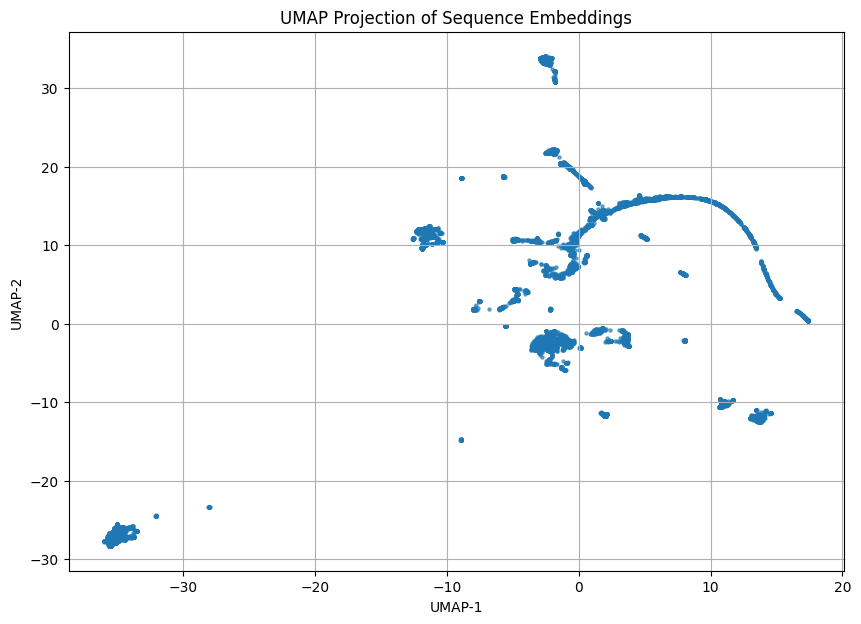

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

# Load embeddings
embeddings = np.load("embeddings_PP_10k.npy")

# Optional: Reduce dimensionality to 2D for visualization
# Use UMAP (preferred for preserving structure)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot UMAP
plt.figure(figsize=(10, 7))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5, alpha=0.6)
plt.title("UMAP Projection of Sequence Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


Apply KMeans clustering to the original sequence embeddings, grouping them into 5 clusters. Then reduce the embeddings to 2D using UMAP for visualization and plot the results, coloring each point by its assigned cluster. This helps visually assess how well the clustering captures structure in the sequence data.


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d4eff7af9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecati

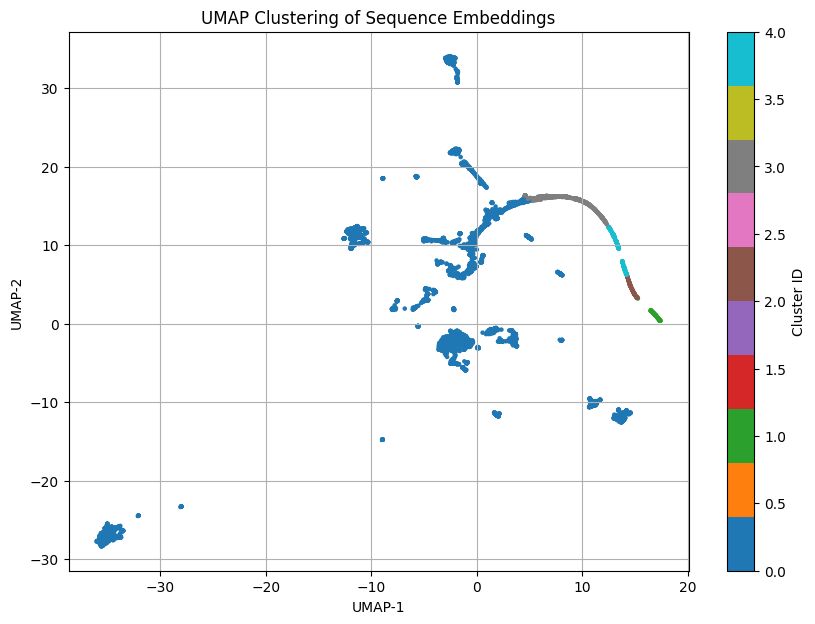

In [ ]:
from sklearn.cluster import KMeans

# Run KMeans on original embeddings
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Plot clusters using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters, cmap='tab10', s=5)
plt.title("UMAP Clustering of Sequence Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()
